In [25]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from keras import Model, Input
from keras.preprocessing import image
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
import glob
import warnings
warnings.filterwarnings('ignore')

( Load data / Adding Noise / Train-Validation- Test )
(from Activity #5.1 – 5.2)

In [26]:
filenames = glob.glob("lab5_files/face_mini/*/*.jpg")
len(filenames)

# Load image files and Resize (h,w,ch) -> h = w < 100 , ch = 3 (R,G,B)
all_images = []

for idx, img_path in enumerate(filenames):
    img = image.load_img(img_path, target_size=(100, 100), interpolation="nearest")
    # convert the image to an array
    img = image.img_to_array(img)
    # Normalized color imageimg
    img = img / 255
    all_images.append(img)
    # if idx == 50:
    #   break

all_images = np.array(all_images)

# split data into train and validation data
train_x, test_x = train_test_split(all_images, random_state=32, test_size=0.3)
train_x, val_x = train_test_split(train_x, random_state=32, test_size=0.3)

noise_factor = 0.8 # scalar between 0 -1 ลองอย่ํางน้อย 2 ค่ํา
Nmean = 0
Nstd = 1

# use np.random.normal to generate normal distribution (gaussian) noise
x_train_noisy = train_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=train_x.shape) )
x_val_noisy = val_x + ( noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=val_x.shape) )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


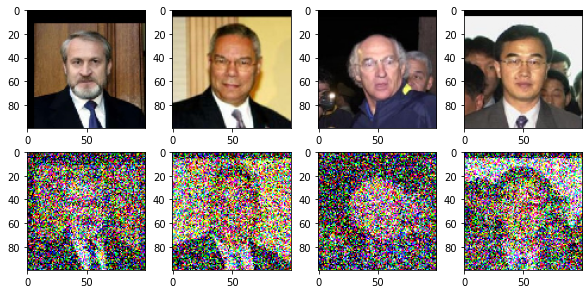

In [27]:
fig = plt.figure(figsize=(10, 10))
size = 4
for i in range(0, size):
  fig.add_subplot(size, size, i+1)
  plt.imshow(train_x[i], cmap="jet")
  fig.add_subplot(size, size, size+i+1)
  plt.imshow(x_train_noisy[i], cmap="jet")
  

Autoencoder

In [28]:
# create_model function
def create_model(optimizer='adam'):
  Input_img = Input(shape=(100, 100, 3))
  # encoder layers
  #encoding architecture
  x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
  x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
  x2 = MaxPool2D( (2, 2))(x2)
  encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
  # decoding architecture
  x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
  x3 = UpSampling2D((2, 2))(x3)
  x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
  x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
  decoded = Conv2D(3, (3, 3), padding='same')(x1)
  # construct the autoencoder model
  autoencoder = Model(Input_img, decoded)
  autoencoder.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mean_squared_error'])
  return autoencoder

In [29]:
# ประกําศ KERAS ตัวจัดกํารพํารํามิเตอร์ของ Model
model = KerasRegressor(build_fn=create_model, epochs=2, batch_size=16, verbose=0)

# 6.3 Create GridSearchCV()

In [30]:
# ก ําหนด Grid Search parameters
optimizer = ['SGD', 'RMSprop', 'Adadelta', 'Adam']
batch_size = [8, 16, 32]
epochs = [2,4,6]
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer)

grid = GridSearchCV( estimator=model,
                      verbose= 0,
                      cv=2,
                      n_jobs=1,
                      param_grid = param_grid,)

grid_result = grid.fit(x_train_noisy, train_x)
print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

KeyboardInterrupt: 

In [ ]:
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f} with: %r" % (mean, stdev, param))

In [ ]:
# ก ําหนด Grid Search parameters
random_search = {'optimizer': ['SGD', 'RMSprop', 'Adadelta', 'Adam'],
                 'batch_size': list(np.linspace(8, 64, 5, dtype = int)),
                 'epochs': list(np.linspace(1, 10, 4, dtype = int))}

In [ ]:
grid_rand = RandomizedSearchCV( estimator=model,
                                verbose= 0,
                                cv=2,
                                random_state = 10,
                                n_iter = 10,
                                n_jobs=1,
                                param_distributions=random_search)

In [ ]:
grid_rand_result = grid_rand.fit(x_train_noisy, train_x)
print('Best params: ',grid_rand_result.best_params_)
print('Best score: ', grid_rand_result.best_score_)
_means = grid_result.cv_results_['mean_test_score']
_stds = grid_result.cv_results_['std_test_score']
_params = grid_result.cv_results_['params']